In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u

# Pulling the Unresolved Binaries from O'Brien (Table A4)

In [2]:
Gaia_DR3_Id = [1355264565043431040, 
               3223516063958808064,
               1005873614080407296,
               2185710338703934976,
               4788741548375134336,
               6431977687725247104,
               3729017810434416128,
               1548104507825815296,
               1550299304833675392,
               4478524169500496000,
               2643862402903084544,
               3845263368043086080,
               759601941671398272,
               3000597125173673088]


In [15]:
query = """
SELECT
    gs.source_id,                
    gs.ra,                      
    gs.dec,                     
    gs.parallax,               
    gs.phot_g_mean_mag,        
    ap.classprob_dsc_combmod_whitedwarf, 
    ap.classprob_dsc_combmod_binarystar,
    ap.teff_gspphot,
    ap.lum_flame,
    ap.radius_flame,
    ap.mass_flame
FROM
    gaiadr3.gaia_source AS gs   
LEFT JOIN
    gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE
    gs.source_id IN (
        1355264565043431040, 
        3223516063958808064,
        1005873614080407296,
        2185710338703934976,
        4788741548375134336,
        6431977687725247104,
        3729017810434416128,
        1548104507825815296,
        1550299304833675392,
        4478524169500496000,
        2643862402903084544,
        3845263368043086080,
        759601941671398272,
        3000597125173673088
    )
"""


In [16]:
job = Gaia.launch_job(query)
results = job.get_results()

# Galactocentric coordinates

In [18]:
# Turning the string into integers
parallax = results['parallax']
parallax = np.array(parallax)

ra = results['ra']
ra = np.array(ra)

dec = results['dec']
dec = np.array(dec)

#using parallax for postion 
arcsecond = parallax/1000
distance = abs(1/arcsecond)
coords = SkyCoord(ra*u.deg, dec*u.deg, distance*u.pc , frame='icrs')
galactic = coords.transform_to(Galactic)

#gives postions 
X = (galactic.cartesian.x)/u.pc
Y = (galactic.cartesian.y)/u.pc
Z = (galactic.cartesian.z)/u.pc

In [23]:
# Create a dictionary with the results and the boundary parameters
data = {
    'source_id' : results['SOURCE_ID'],
    'ra' : results['ra'],
    'dec' : results['dec'],
    'parallax' : results['parallax'],
    'phot_g_mean_mag' : results['phot_g_mean_mag'],
    'WD_prob' : results['classprob_dsc_combmod_whitedwarf'],
    'Binary_prob' : results['classprob_dsc_combmod_binarystar'],
    'T_eff' : results['teff_gspphot'],
    'lum_flame' : results['lum_flame'],
    'radius_flame' : results['radius_flame'],
    'mass_flame' : results['mass_flame'],
    'X' : X,
    'Y' : Y,
    'Z' : Z 
}
df = pd.DataFrame(data)

Text(0, 0.5, 'Y axis (pc)')

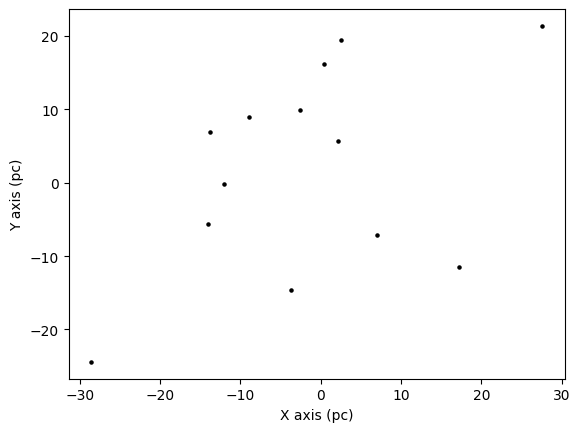

In [28]:
plt.scatter(df['X'], df['Y'], c='k', s=5)
plt.xlabel('X axis (pc)')
plt.ylabel('Y axis (pc)')